In [1]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr
    
# plot
import cartopy.crs as ccrs
import cartopy.feature as ccf
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import scipy.io

%matplotlib inline 

In [2]:
### local (my laptop)
diri = "/Users/leroux/DATA/OCCIPUT_DATA/ORCA025.L75/MOC/"
fili = "AMOCSIG.ORCA025.L75-OCCITENS.1960-2015.nc"

# Read AMOC monthly dataset
(all 50 members)

In [3]:
amoc = xr.open_dataset(diri+fili)['amoc']

# Examples using the AMOC dataset

* __Very simple plot of the timeseries of amoc at 26N for member #1 and member #10 :__

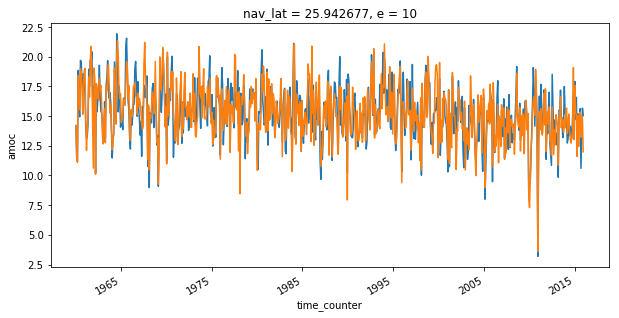

In [4]:
rapidmb1 = amoc.sel(nav_lat=26.,method='nearest',e=1)
rapidmb2 = amoc.sel(nav_lat=26.,method='nearest',e=10)

# plot 
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
rapidmb1.plot()
rapidmb2.plot()

* __Compute and plot ensemble-mean AMOC and ensemble-std AMOC at a given latitude:__

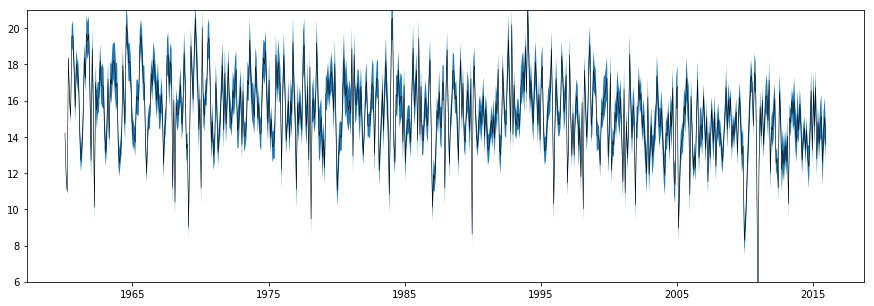

In [5]:
# choose latitude
latchoice = 26.

emean = amoc.mean(dim='e')
estd  = amoc.std(dim='e')

emeanplus = emean+estd
emeanminus = emean-estd


y  = emean.sel(nav_lat=latchoice,method='nearest')
yp = emeanplus.sel(nav_lat=latchoice,method='nearest')
ym = emeanminus.sel(nav_lat=latchoice,method='nearest')

x=emean.time_counter.values

# plot
fig2 = plt.figure(figsize=([15,5]),facecolor='white')  

# emean (black)
plt.plot(x,y,color='k',linewidth=0.5)
# emean +/- 1sd shaded (blue)
plt.fill_between(x,ym,yp)

plt.ylim( 6., 21. )  

plt.show()



--> note that there is a large seasonal cycle that blurs the above plot. Below i show an example where the seasonal cycle is first remove.

* __Time-mean value of the e-std at 34.5S:__

In [6]:
latchoice = -34.5
tmestd = estd.sel(nav_lat=latchoice,method='nearest').mean(dim='time_counter')
tmestd.values

array(1.72815234)

--> consistent with the e-spread values i had of the monthly amoc in my previous study (see fig from DRAKKAR meeting)

# Now detrend the amoc dataset with a loess method 
Detrended as in Leroux et al 2018: 

_S. Leroux, T. Penduff, L. Bessieres, J.-M. Molines, J.-M. Brankart, G. Serazin, B. Barnier, and L. Ter- ray. Intrinsic and atmospherically forced variability of the amoc: Insights from a large-ensemble ocean hindcast. Journal of Climate, 31(3):1183–1203, 2018._

In [8]:

import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
# Since rpy2 version 2.3, it is necessary to activate the automatic 
# conversion from numpy to R arrays
if hasattr(rpy2.robjects.numpy2ri, 'activate'):
   rpy2.robjects.numpy2ri.activate()

################################################
################################################
def loess_detrend(ts, time, span=0.99, degree=2):
    """ non-linear loess detrending inspired from Guillaume Serrazin's tools
        Uses R package for Python
        This loess filter is set for parameters (span 0.99, degree=2) that
        are equivalent to a HP filter of cutoff period = half the total time-segment.
        
        Note: wgts is a vector containing the weights to apply on the operator for each time-step. T
        he normal usage is to set wgts to 0.   Ex:  wgts = np.ones(len(data) ). But sometimes you might
        need to impose that the first time step of the timeseries (data[0]) should be invariant through 
        the loess operator. In that case, just set the first weight to a high number. Ex: wgts[0]=1000.  
    """
    rloess = robjects.r['loess']
    fmla = robjects.Formula('y ~ x')
    env = fmla.environment
    env['x'] = time
    env['y'] = ts
    ts_dtr = np.array(rloess(fmla, span=span, degree=degree)[2])
    return ts_dtr

### apply detrending on the entire amoc dataset

In [13]:
il=1
ie=1
for ie in range(0,amoc.e.size):
    
    for il in np.arange(0,amoc.nav_lat.size):  
        # timeseries with time-mean removed
        ts   = amoc.isel(nav_lat=il,e=ie).values
            
        # apply detrending
        ts_dt = loess_detrend(ts, \
                       np.arange(0,amoc.time_counter.size,1), \
                       span=0.99, degree=2)
        
        tmp = xr.DataArray(ts_dt, dims=('time_counter'),coords={'time_counter':amoc.time_counter})
        if (il!=0):
            concamoc = xr.concat([concamoc,tmp], dim='nav_lat')
        else:
            concamoc = tmp
    if (ie!=0):
        concconcamoc = xr.concat([concconcamoc,concamoc], dim='e')
    else:
        concconcamoc = concamoc
        
# make sure the time mean is exactly zero
concconcamoc = concconcamoc - concconcamoc.mean(dim='time_counter')

## Save the output (detrended) dataset

In [15]:
# change dims order so that it is the same as the non-detrended dataset
amoc_dt1 = concconcamoc.transpose('time_counter','e','nav_lat')

# redefine coordinate
amoc_dt1_def =  xr.DataArray(amoc_dt1.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':amoc.time_counter,'e': amoc.e, 'nav_lat': amoc.nav_lat})

# output
outfi = diri+'AMOCSIG.ORCA025.L75-OCCITENS.1960-2015_dt.nc'
amoc_dt1_def.name='amoc_dt'
amoc_dt1_def.attrs['long_name'] =  "detrended amoc (loess)"
amoc_dt1_def.to_netcdf(outfi,mode='w')

## Read and plot the detrended dataset

In [16]:
## READ
amoc_dtREAD = xr.open_dataset(diri+'AMOCSIG.ORCA025.L75-OCCITENS.1960-2015_dt.nc')['amoc_dt']

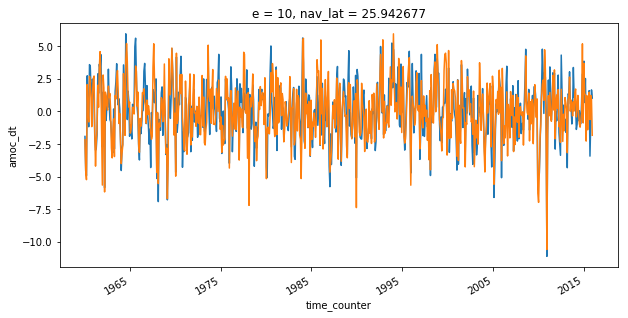

In [17]:
## PLOT

# select 2 members (1 and 10) at 26ºN
rapidmb1 = amoc_dtREAD.sel(nav_lat=26.,method='nearest',e=1)
rapidmb2 = amoc_dtREAD.sel(nav_lat=26.,method='nearest',e=10)

# plot timeseries
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
rapidmb1.plot()
rapidmb2.plot()

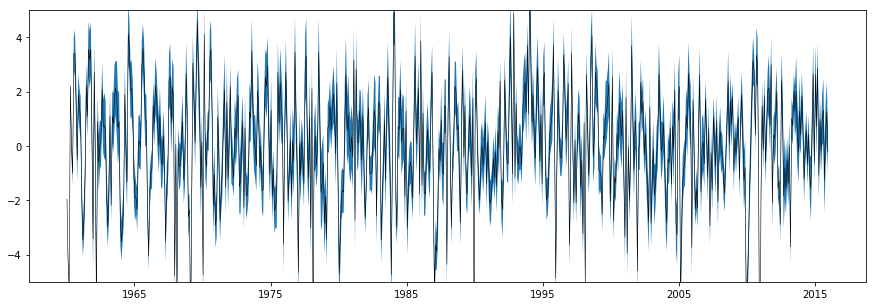

In [21]:
## PLOT ensemble-mean, and envelop for ensemble mean -/+1std (detrended data)

# choose latitude
latchoice = 26.

emean = amoc_dtREAD.mean(dim='e')
estd  = amoc_dtREAD.std(dim='e')

emeanplus = emean+estd
emeanminus = emean-estd


y  = emean.sel(nav_lat=latchoice,method='nearest')
yp = emeanplus.sel(nav_lat=latchoice,method='nearest')
ym = emeanminus.sel(nav_lat=latchoice,method='nearest')

x=emean.time_counter.values

# plot
fig2 = plt.figure(figsize=([15,5]),facecolor='white')  

# emean (black)
plt.plot(x,y,color='k',linewidth=0.5)
# emean +/- 1sd shaded (blue)
plt.fill_between(x,ym,yp)

plt.ylim( -5., 5. )  

plt.show()